# Финальный проект: Прогнозирование оттока клиентов

## Неделя 1: Описательный анализ данных


В рамках проекта мы будем решать задачу прогнозирования оттока пользователей, или churn prediction. Эта задача заключается в прогнозировании вероятности того, что клиент перестанет пользоваться сервисом в течение некоторого заданного заранее промежутка времени, например, решит перейти к конкуренту или откажется от использования услуги данного типа вообще.

Данные были предоставлены французской телекоммуникационной компанией Orange. В задаче речь идет о клиентских данных, поэтому данные были предварительно обфусцированы и анонимизированны: из датасета убрана любая персональная информация, позволяющая идентифицировать пользователей, а также не представлены названия и описания переменных, предназначенных для построения прогнозов. Мы будем работать с набором данных orange small dataset. Он состоит из 50 тыс. объектов и включает 230 переменных, из которых первые 190 переменных - числовые, и оставшиеся 40 переменные - категориальные.

В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых "закрытых" данных - данных, которые предоставляются для анализа и построения моделей без описания.

In [1]:
# библиотеки, настройки
import pandas as pd
import numpy as np
import random
import os
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#### 1. Загрузите данные orange_small_churn_data.train и orange_small_churn_labels.train

In [2]:
PATH = '.\data'
data = pd.read_csv(os.path.join(PATH,'orange_small_churn_data.train'))
label = pd.read_csv(os.path.join(PATH,'orange_small_churn_labels.train'))

In [3]:
print (data.shape)
print (label.shape)

(40000, 230)
(39999, 1)


In [4]:
# имена категориальных и числовых переменных
features_num = data.columns[0:190]
features_cat = data.columns[190:230]

#### 2. Рассчитайте доли классов “отток” и “не отток”.
Мне удобнее работать с ноликами и единичками, поэтому я заменю все -1 на 0:

In [5]:
label['target'] = label[label.columns[0]].map({-1:0,1:1})

In [6]:
label['target'].value_counts()

0    37028
1     2971
Name: target, dtype: int64

In [7]:
print('churn:', len(label[label['target']==0])/len(label['target']))
print('no_churn:', len(label[label['target']==1])/len(label['target']))

churn: 0.925723143078577
no_churn: 0.07427685692142304


#### 3. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Т.к. целевая переменная бинарная, то нам не подойдет расчет корреляции Пирсона. 

Будем считать корреляцию для численных признаков  и целевой переменной как разность матожиданий признака для обоих классов целевой переменной. 

Для категориальных признаков будем счиать корреляцию через коэффициент Крамера.

#### Числовые признаки

In [8]:
data_num = data[features_num]
data_num.shape

(40000, 190)

In [25]:
print(len(data.columns[data.isnull().sum()>25000]))
print(len(data.columns[data.isnull().sum()>30000]))
print(len(data.columns[data.isnull().sum()>35000]))
print(len(data.columns[data.isnull().sum()>39000])) #83 числовых признака имеют пропуска более чем в 39000 объектах
print(len(data.columns[data.isnull().sum()>39500])) 
print(len(data.columns[data.isnull().sum()>39900])) 
print(len(data.columns[data.isnull().sum()<20000]))
print(len(data.columns[data.isnull().sum()<30000])) 

156
154
154
83
27
18
69
76


In [27]:
set_more_25000 = set(data.columns[data.isnull().sum()>25000])
set_more_35000 = set(data.columns[data.isnull().sum()>35000])
set_more_39000 = set(data.columns[data.isnull().sum()>39000]) 
set_more_39500 = set(data.columns[data.isnull().sum()>39500]) 
set_more_39900 = set(data.columns[data.isnull().sum()>39900]) 
set_less_30000 = set(data.columns[data.isnull().sum()<30000])
set_less_20000 = set(data.columns[data.isnull().sum()<20000]) 

Числовые признаки имеют большое колличество пропусков.

In [9]:
data_num = pd.concat([data_num, label['target']], axis=1)
corr_num = data_num[data_num['target']==1].mean() - data_num[data_num['target']==0].mean()

In [61]:
corr_num.sort_values(ascending=False)[:10] #топ 10 числовых признаков, которые коррелируют сильнее всего (+ корреляция)

Var69     385678.007143
Var182    189847.563351
Var92     121792.034661
Var114    117287.285400
Var10     100711.810909
Var5       83279.681818
Var177     73389.848058
Var171     63281.731668
Var139     58074.160433
Var36      46644.580685
dtype: float64

In [30]:
#число пропусков в признаках, которые коррелируют сильнее всего с целевой переменной
data_num[corr_num.sort_values(ascending=False)[:10].index].isnull().sum() 

Var69     38795
Var182    38707
Var92     39875
Var114    38962
Var10     38795
Var5      38795
Var177    38962
Var171    39094
Var139    38795
Var36     38962
dtype: int64

In [66]:
corr_num.sort_values(ascending=True)[:10] #топ 10 числовых признаков, которые коррелируют сильнее всего (- корреляция)

Var131   -2.135318e+06
Var180   -1.621357e+05
Var53    -1.526592e+05
Var153   -8.873889e+04
Var58    -8.031515e+04
Var133   -4.260173e+04
Var70    -3.930676e+04
Var38    -3.709648e+04
Var56    -2.607299e+04
Var76    -1.948998e+04
dtype: float64

In [31]:
#число пропусков в признаках, которые коррелируют сильнее всего с целевой переменной
data_num[corr_num.sort_values(ascending=True)[:10].index].isnull().sum() 

Var131    39453
Var180    39451
Var53     39451
Var153     4085
Var58     39451
Var133     4085
Var70     38795
Var38      4085
Var56     39449
Var76      4085
dtype: int64

In [197]:
corr_num.map(lambda x: abs(x)).sort_values(ascending=False)[:10] #топ 10 числовых признаков, которые коррелируют сильнее всего

Var131    2.135318e+06
Var69     3.856780e+05
Var182    1.898476e+05
Var180    1.621357e+05
Var53     1.526592e+05
Var92     1.217920e+05
Var114    1.172873e+05
Var10     1.007118e+05
Var153    8.873889e+04
Var5      8.327968e+04
dtype: float64

In [33]:
#число пропусков в признаках, которые коррелируют сильнее всего с целевой переменной
data_num[corr_num.map(lambda x: abs(x)).sort_values(ascending=False)[:10].index].isnull().sum() 

Var131    39453
Var69     38795
Var182    38707
Var180    39451
Var53     39451
Var92     39875
Var114    38962
Var10     38795
Var153     4085
Var5      38795
dtype: int64

In [43]:
#число различных значений в признаках, которые коррелируют сильнее всего с целевой переменной
[(col,len(data_num[col].unique())) for col in data_num[corr_num.map(lambda x: abs(x)).sort_values(ascending=False)[:10].index]]

[('Var131', 117),
 ('Var69', 677),
 ('Var182', 680),
 ('Var180', 437),
 ('Var53', 345),
 ('Var92', 125),
 ('Var114', 549),
 ('Var10', 442),
 ('Var153', 29804),
 ('Var5', 472)]

##### Категориальные признаки

In [45]:
features_cat

Index(['Var191', 'Var192', 'Var193', 'Var194', 'Var195', 'Var196', 'Var197',
       'Var198', 'Var199', 'Var200', 'Var201', 'Var202', 'Var203', 'Var204',
       'Var205', 'Var206', 'Var207', 'Var208', 'Var209', 'Var210', 'Var211',
       'Var212', 'Var213', 'Var214', 'Var215', 'Var216', 'Var217', 'Var218',
       'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var224', 'Var225',
       'Var226', 'Var227', 'Var228', 'Var229', 'Var230'],
      dtype='object')

In [46]:
import scipy.stats as ss

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [47]:
data[features_cat]

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,kMJt0GoOh3,RO12,NaN,taul,1K8T,G6s_,6HL7qwL,YIoRSeV,NaN,...,oslk,9HlNxGX,LM8l689qOp,NaN,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,3HjOj17ejg,RO12,NaN,taul,1K8T,aD1X,AAScNhj,Fgbe8NN,NaN,...,oslk,JaZwBif,jySVZNlOJy,NaN,NaN,7aLG,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,1YVgUHXZeb,RO12,NaN,taul,1K8T,7ALb,WIUdTJr,lGXpFd_2Rf,3Vucl6U,...,oslk,9JvQQMs,LM8l689qOp,NaN,ELof,453m,RAYp,F2FyR07IdsN7I,mj86,NaN
3,NaN,zKnr4RXktW,RO12,NaN,taul,1K8T,PbOJ,Mqscy5d,EG2hH7KmXr,jhomLZ5,...,oslk,xmA7A2G,LM8l689qOp,NaN,ELof,Xa3G,RAYp,F2FyR07IdsN7I,am7c,NaN
4,NaN,639TmBQxul,RO12,NaN,taul,1K8T,TyGl,XX3Juq4,76j2P_OLn0,NaN,...,oslk,PSKQZmh,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,NaN,3HjOj17ejg,RO12,NaN,taul,1K8T,oXaB,32pvHAP,6uerj6GG35,NaN,...,oslk,z042C8o,LM8l689qOp,NaN,NaN,7aLG,RAYp,F2FyR07IdsN7I,NaN,NaN
39996,NaN,EsYrjIX0Db,JXVE,NaN,taul,1K8T,0Xwj,EXEOT3E,r83_sZi,rJ0kKt9,...,oslk,s20oIp0,LM8l689qOp,NaN,ELof,5Acm,RAYp,F2FcTt7IdMT_v,mj86,NaN
39997,NaN,DQlgUH7IEC,RO12,NaN,taul,1K8T,487l,lUpdCrr,yLQsa0Xacm,NaN,...,oslk,G9lTL5Q,jySVZNlOJy,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN
39998,NaN,vAsgUHXM47,g62hiBSaKg,NaN,taul,1K8T,JLbT,fhk21Ss,LH0kFz12FM,QK2P6Wo,...,zCkv,catzS2D,LM8l689qOp,NaN,ELof,453m,ZI9m,ib5G6X1eUxUn6,am7c,NaN


In [48]:
from sklearn import preprocessing
for feature in features_cat:
    le = preprocessing.LabelEncoder()
    le.fit(data[feature].astype(str))
    data[feature] = le.transform(data[feature].astype(str))

In [49]:
cramer_list = list()
for features in features_cat:
    confusion_mx = pd.crosstab(label['target'], data[features])
    cramer_list.append(cramers_corrected_stat(confusion_mx))
len(cramer_list)

C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


40

In [54]:
data_cor_cat = pd.DataFrame(cramer_list, index=features_cat, columns=['cor_cat'])
data_cor_cat.sort_values(by='cor_cat', ascending=False)[:10] #топ 10 категориальных признаков коррелирующих с целевой переменнй

,cor_cat
Var204,0.025840
Var193,0.018377
Var195,0.014931
Var206,0.014117
Var221,0.009943
Var219,0.009914
Var226,0.009565
Var218,0.007806
Var228,0.005743
Var223,0.005520


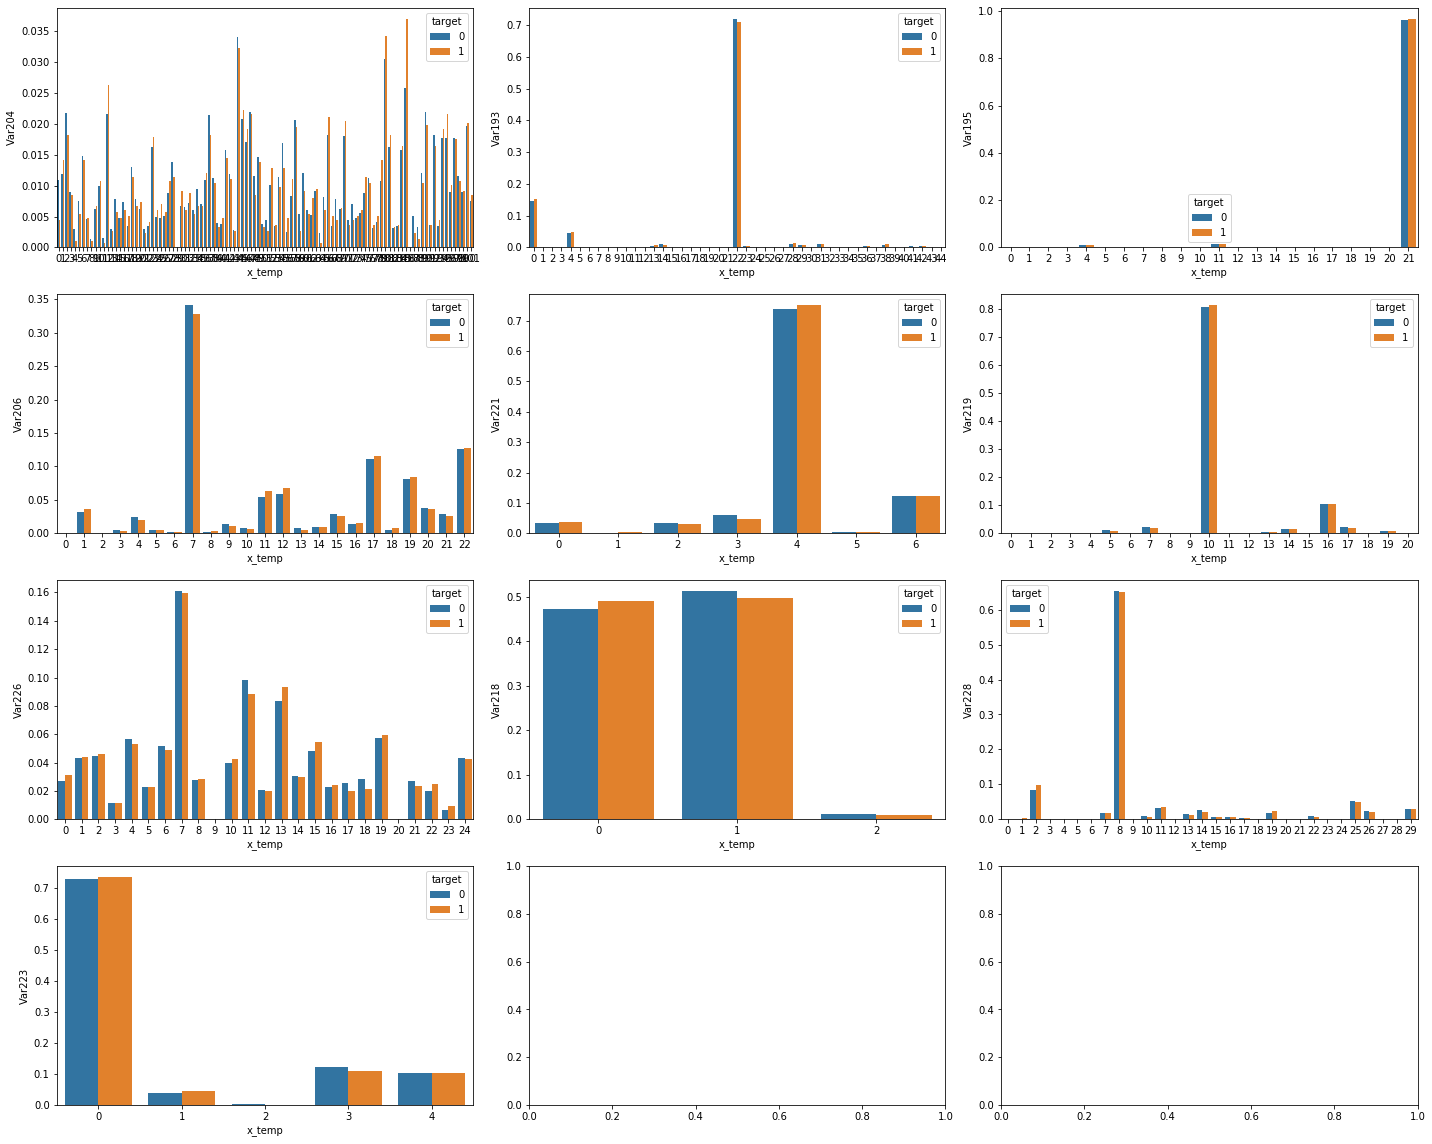

In [71]:
#категориальные признаки, которые коррелируют сильнее всего с целевой переменной
features = data_cor_cat.sort_values(by='cor_cat', ascending=False)[:10].index
data['target'] = label['target']
data_cat_new = data[list(features) + ['target']]
len1_class = data_cat_new[data_cat_new['target']==1].shape[0]
len0_class = data_cat_new[data_cat_new['target']==0].shape[0]

fig, axes = plt.subplots(4, 3, figsize=(20, 16))
for i, fear in enumerate(features):
    temp_1 = data_cat_new[fear][data_cat_new['target']==1].value_counts()
    temp_1 = temp_1.apply(lambda x: x/len1_class)
    temp_1 = pd.DataFrame(temp_1)
    temp_1['target']=1

    temp_0 = data_cat_new[fear][data_cat_new['target']==0].value_counts()
    temp_0 = temp_0.apply(lambda x: x/len0_class)
    temp_0 = pd.DataFrame(temp_0)
    temp_0['target']=0

    temp_df = pd.concat([temp_1, temp_0])
    temp_df['x_temp']=temp_df.index

    sns.barplot(x=temp_df['x_temp'], y=temp_df[temp_df.columns[0]], hue=temp_df['target'], ax=axes[i // 3, i % 3])
fig.tight_layout()

#### 4. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте распределения в разрезе классов. Отобразите объекты в координатах пар признаков

In [198]:
top20_num = corr_num.map(lambda x: abs(x)).sort_values(ascending=False)[:20]

In [199]:
top20_num

Var131    2.135318e+06
Var69     3.856780e+05
Var182    1.898476e+05
Var180    1.621357e+05
Var53     1.526592e+05
Var92     1.217920e+05
Var114    1.172873e+05
Var10     1.007118e+05
Var153    8.873889e+04
Var5      8.327968e+04
Var58     8.031515e+04
Var177    7.338985e+04
Var171    6.328173e+04
Var139    5.807416e+04
Var36     4.664458e+04
Var117    4.289277e+04
Var133    4.260173e+04
Var70     3.930676e+04
Var59     3.856332e+04
Var38     3.709648e+04
dtype: float64

In [200]:
top20_num.index

Index(['Var131', 'Var69', 'Var182', 'Var180', 'Var53', 'Var92', 'Var114',
       'Var10', 'Var153', 'Var5', 'Var58', 'Var177', 'Var171', 'Var139',
       'Var36', 'Var117', 'Var133', 'Var70', 'Var59', 'Var38'],
      dtype='object')

In [110]:
data['target'] = label['target']

C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


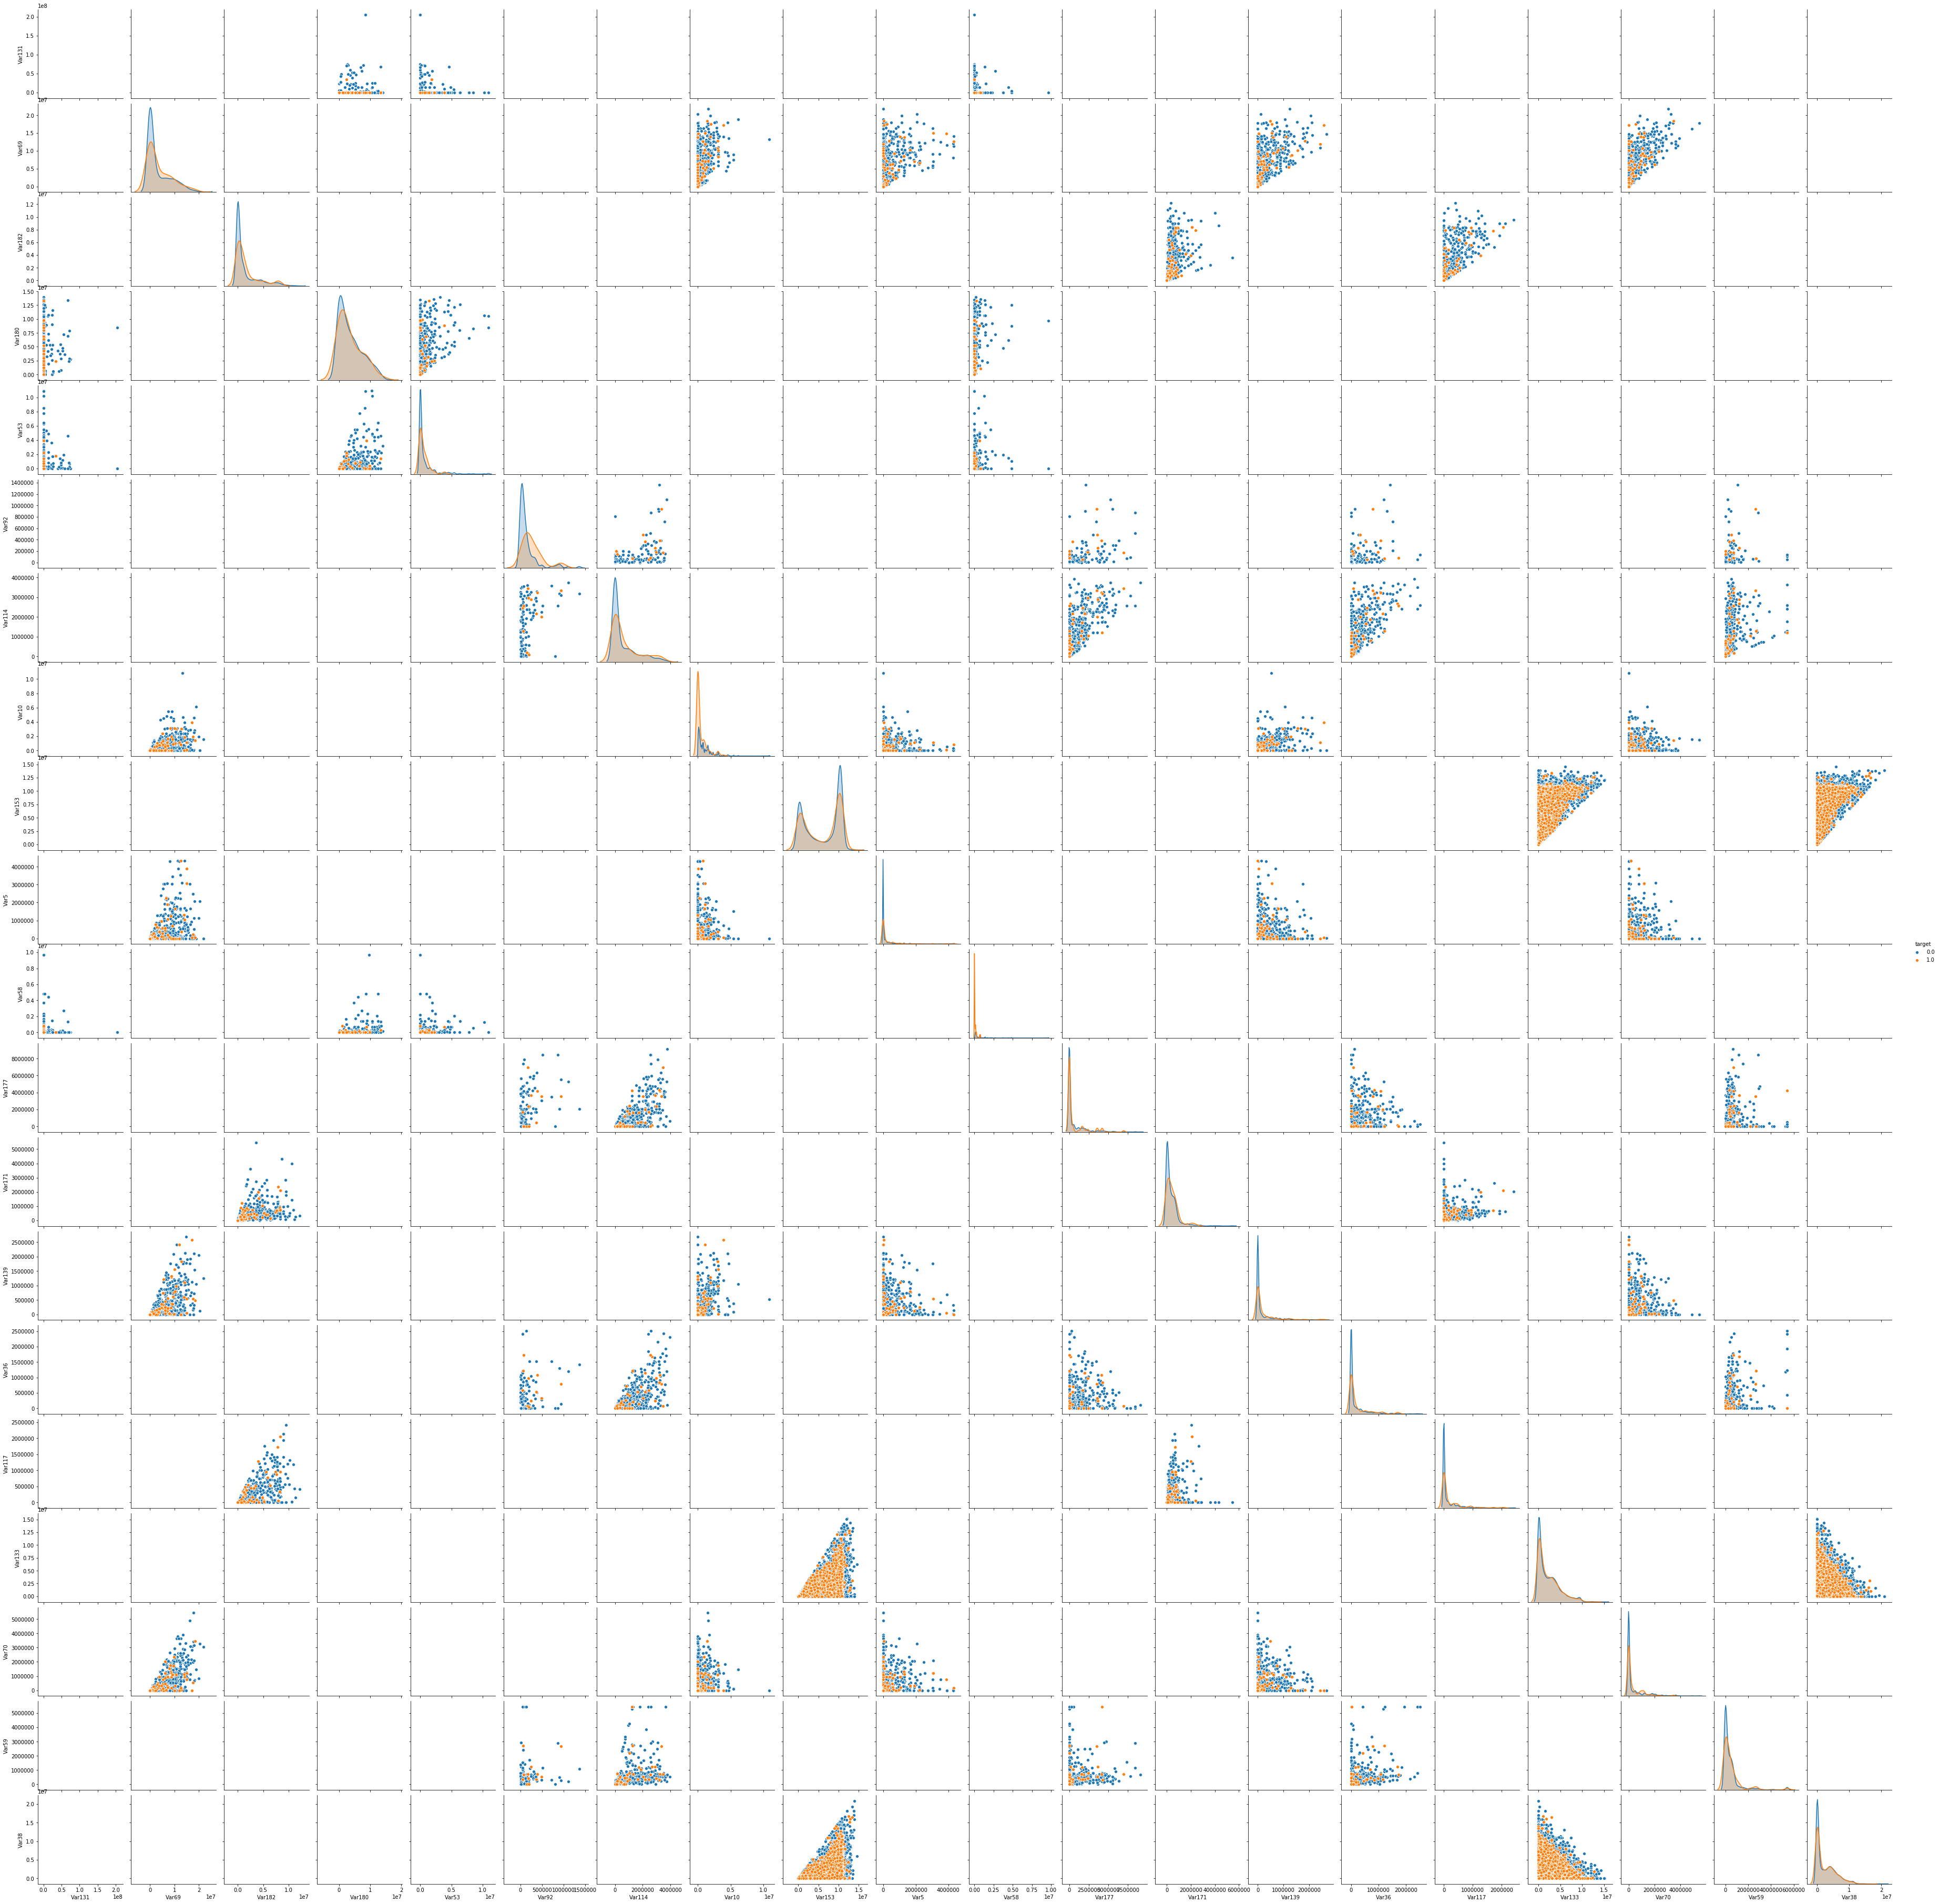

In [201]:
sns.pairplot(data[[ind for ind in top20_num.index] + ['target']], hue="target", diag_kind="kde")
plt.show()

Для большей наглядности можно посмотреть плотности распределения признаков в зависимости от класса не попарно, а отдельно:

C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


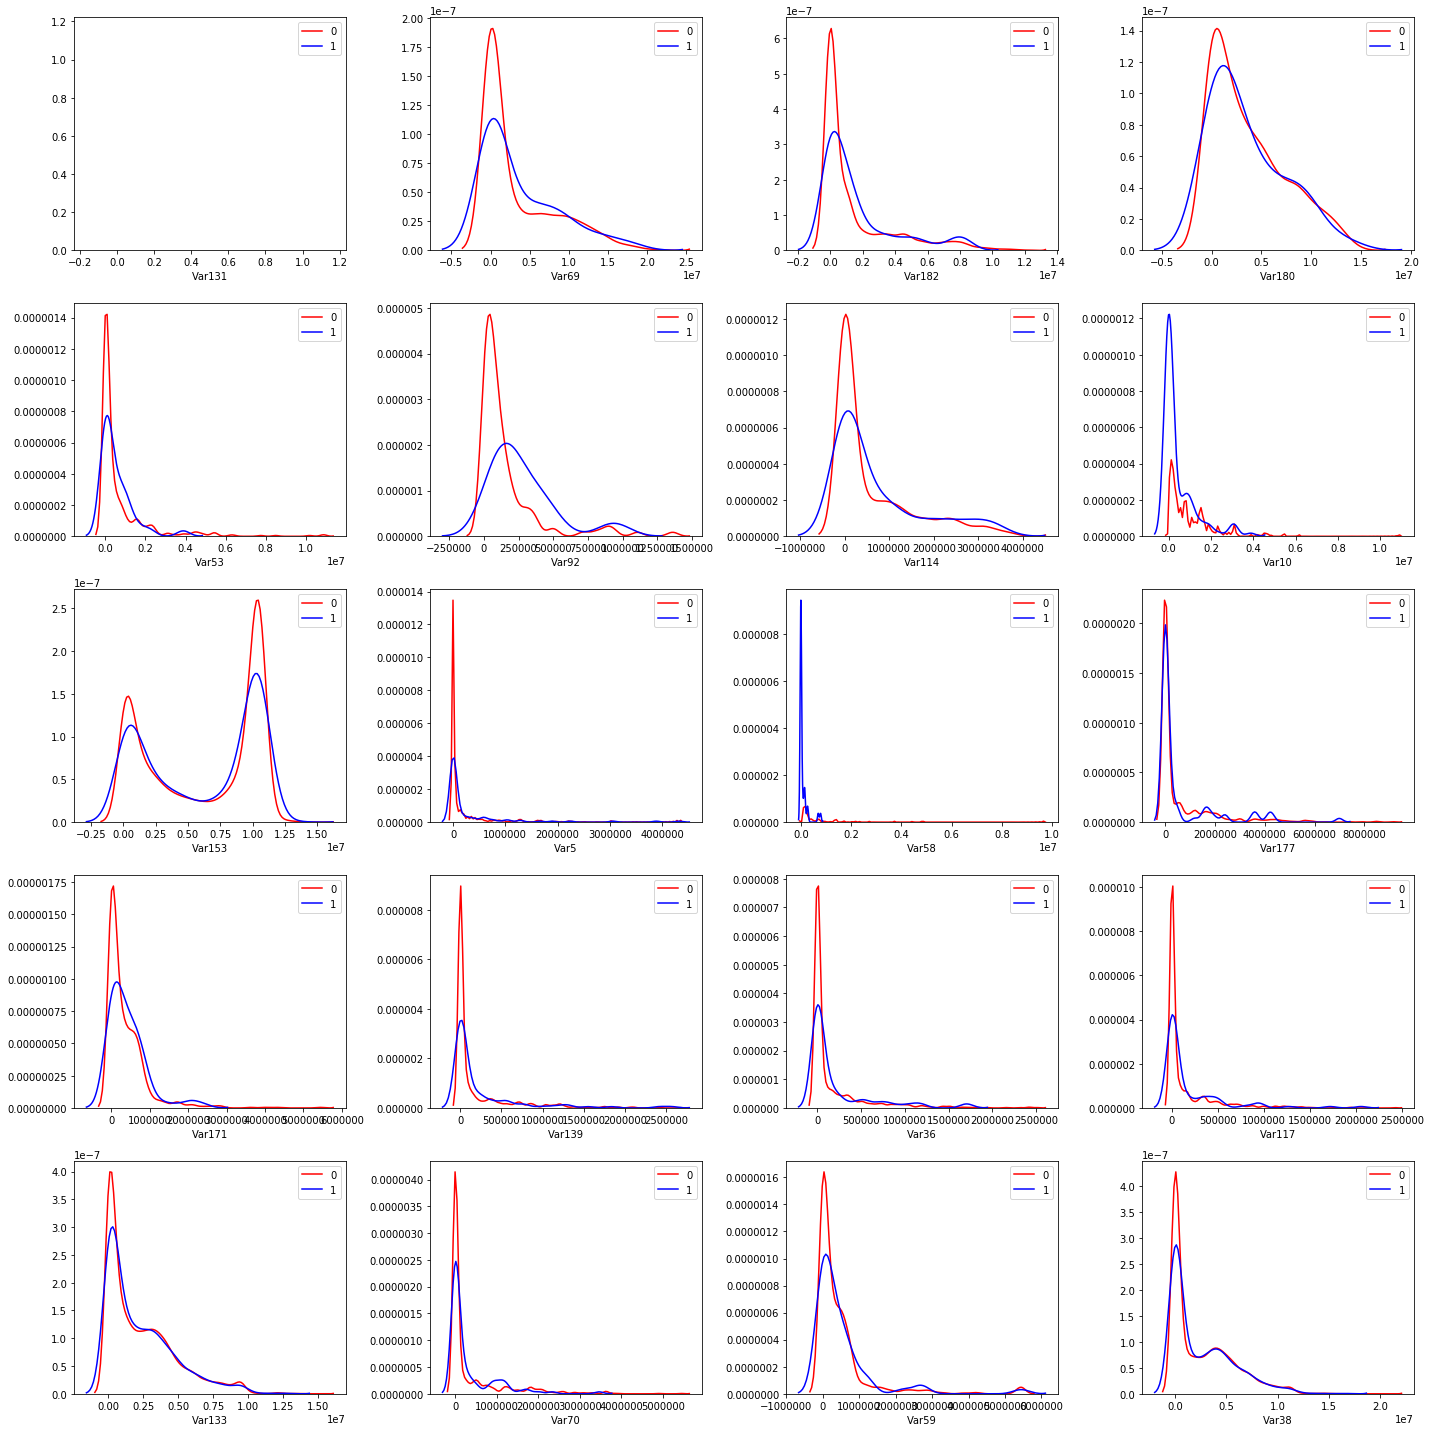

In [202]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
for i in range(len(top20_num)):
    sns.kdeplot(data[data.target == 0][top20_num.index[i]].values, color = 'r', ax=axes[i // 4, i % 4], label=0)
    sns.kdeplot(data[data.target == 1][top20_num.index[i]].values, color = 'b', ax=axes[i // 4, i % 4], label=1)
    axes[i // 4, i % 4].set(xlabel=top20_num.index[i])
fig.tight_layout()

#### 5. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

In [156]:
temp = data[features_num]
temp_feat = temp.isnull().sum().sort_values()[:40].index #признаки с наименьшим числом пропусков

In [171]:
# выберем 10 случайных числовых признаков
np.random.seed(19)
random10_num = np.random.choice(temp_feat, size=10, replace=False)
random10_num

array(['Var6', 'Var24', 'Var112', 'Var123', 'Var35', 'Var74', 'Var132',
       'Var73', 'Var119', 'Var173'], dtype=object)

C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-pa

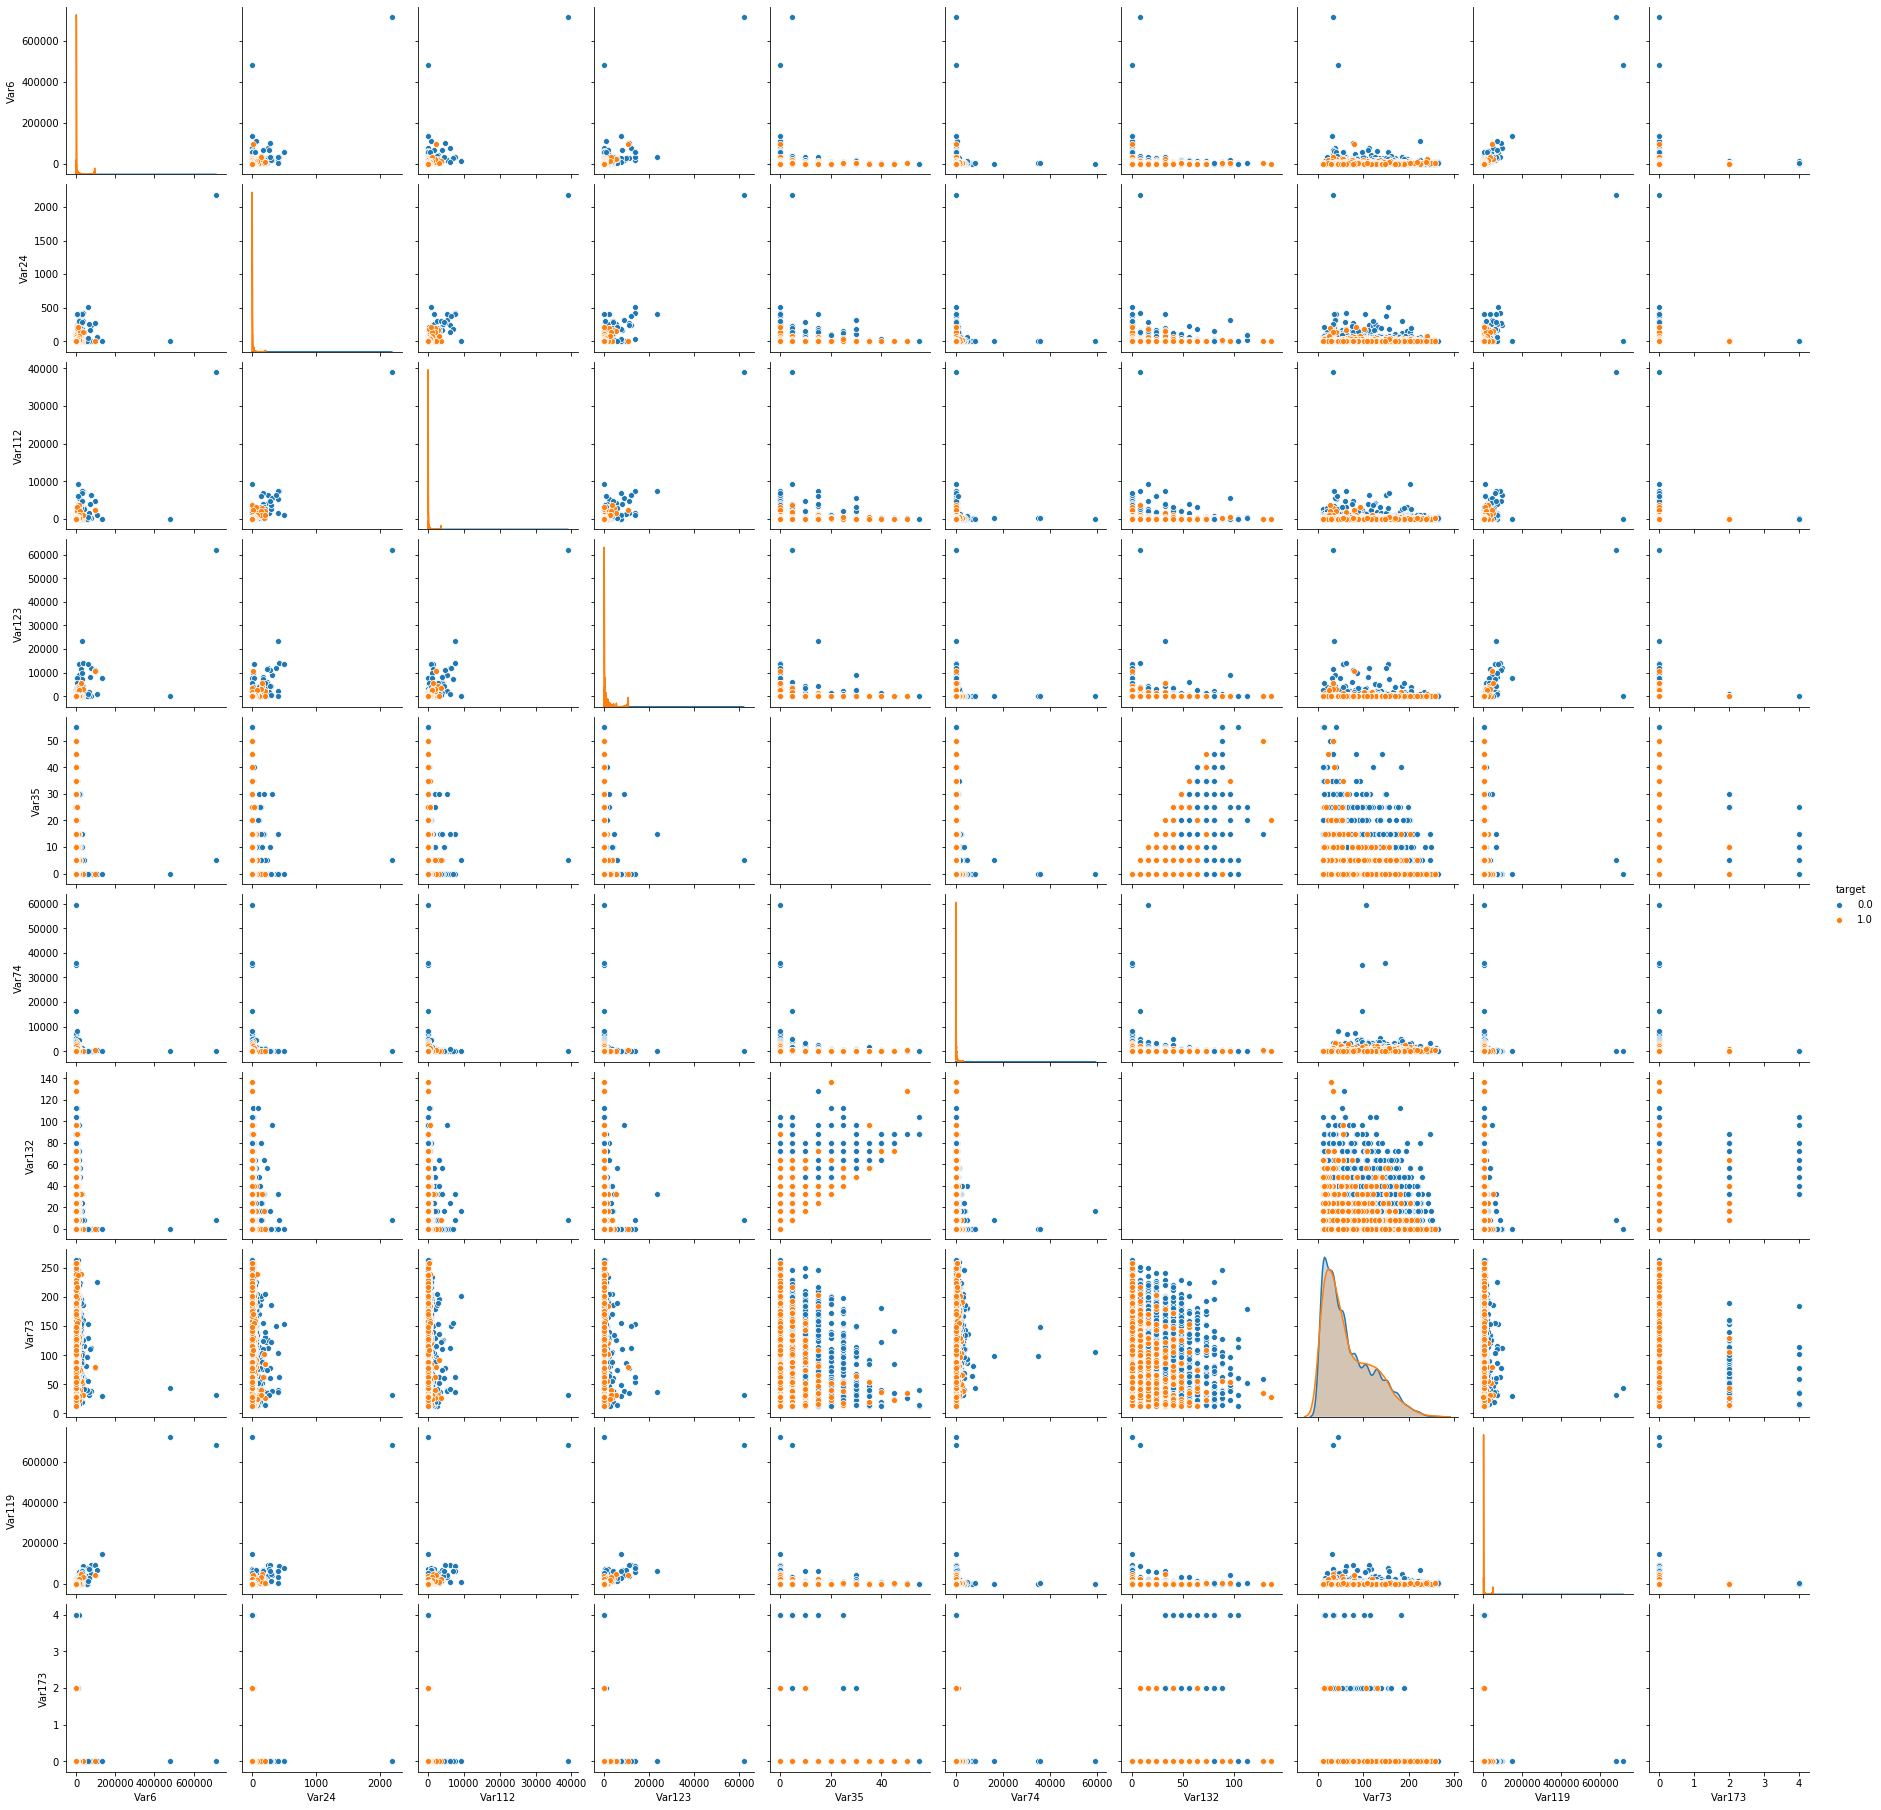

In [173]:
sns.pairplot(data[[ind for ind in random10_num] + ['target']], hue="target", diag_kind="kde")
plt.show()

C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-pa

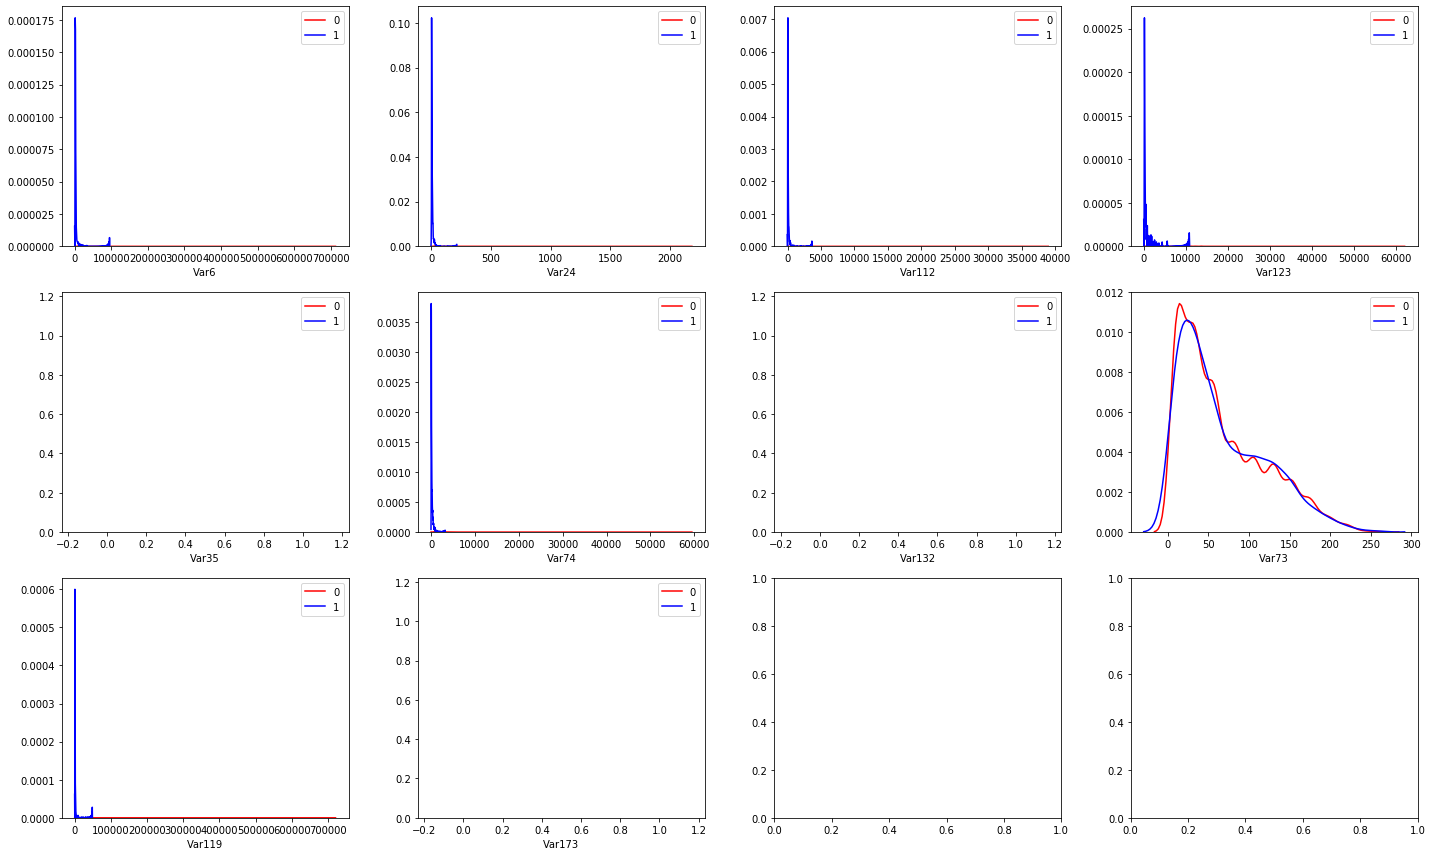

In [182]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
for i in range(len(random10_num)):
    sns.kdeplot(data[data.target == 0][random10_num[i]].values, color = 'r', ax=axes[i // 4, i % 4], label=0)
    sns.kdeplot(data[data.target == 1][random10_num[i]].values, color = 'b', ax=axes[i // 4, i % 4], label=1)
    axes[i // 4, i % 4].set(xlabel=random10_num[i])
fig.tight_layout()

In [185]:
data['Var173'].value_counts() #много нулей в признаках

0.0    35803
2.0      100
4.0       12
Name: Var173, dtype: int64

#### 6. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

In [192]:
bottom_10_num = corr_num.map(lambda x: abs(x)).sort_values(ascending=True)[:10]
bottom_10_num 

Var118    0.000000
Var173    0.000954
Var27     0.002771
Var181    0.004027
Var138    0.005021
Var44     0.005326
Var72     0.005427
Var143    0.005497
Var57     0.012575
Var142    0.023048
dtype: float64

In [193]:
bottom_10_num.index

Index(['Var118', 'Var173', 'Var27', 'Var181', 'Var138', 'Var44', 'Var72',
       'Var143', 'Var57', 'Var142'],
      dtype='object')

C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-pa

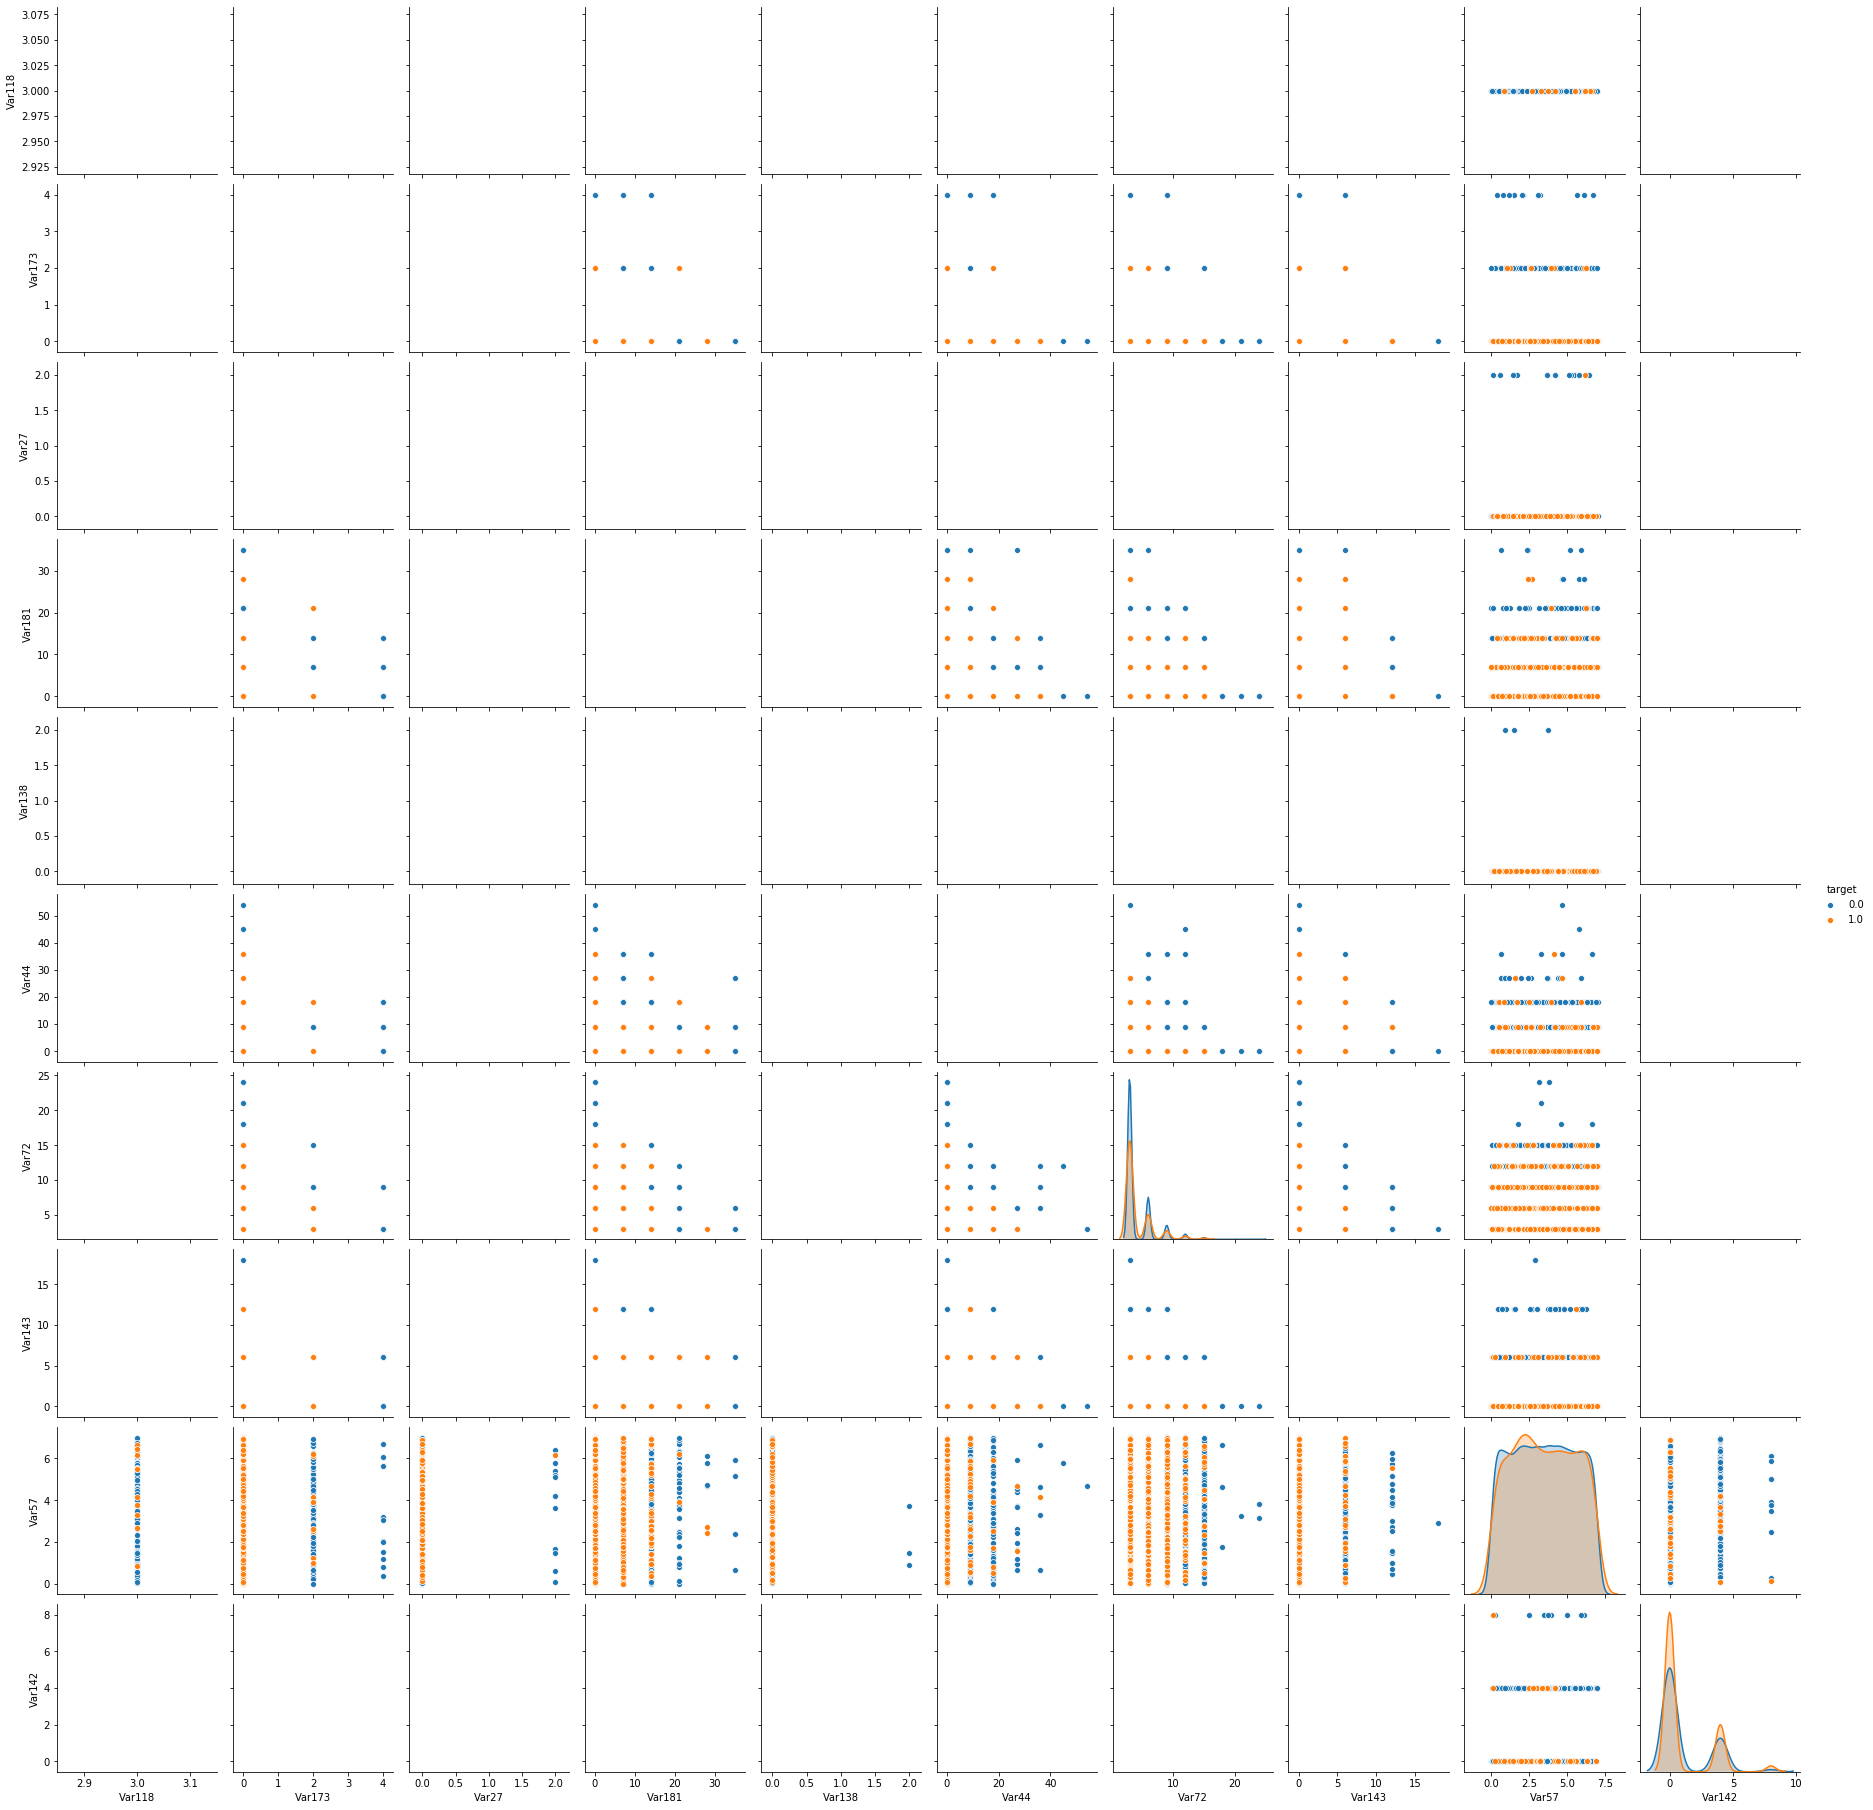

In [194]:
sns.pairplot(data[list(bottom_10_num.index) + ['target']], hue="target", diag_kind="kde")
plt.show()

C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Vladuk\Anaconda2\envs\tf\lib\site-pa

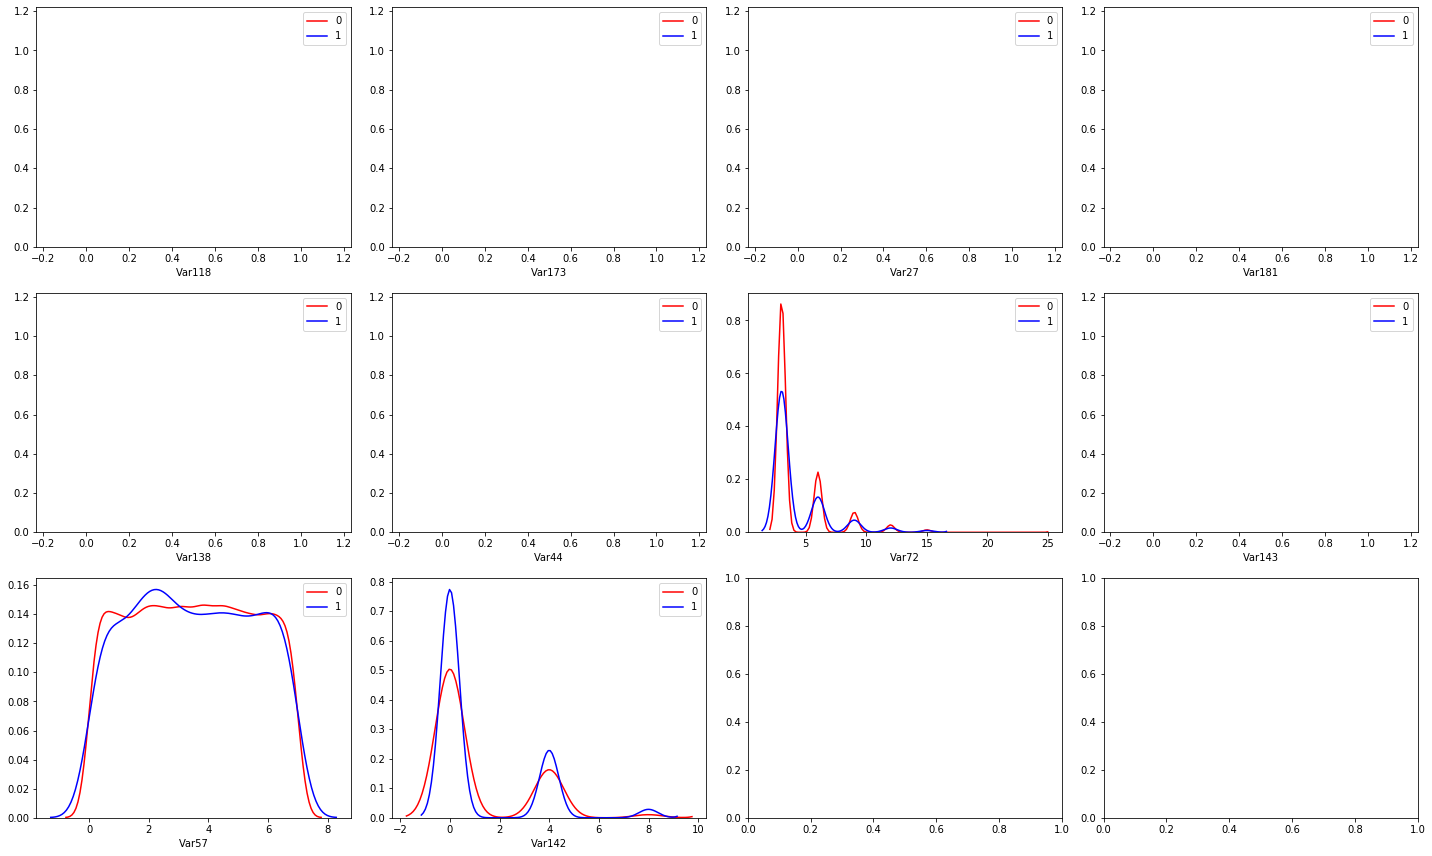

In [196]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
for i in range(len(bottom_10_num.index)):
    sns.kdeplot(data[data.target == 0][bottom_10_num.index[i]].values, color = 'r', ax=axes[i // 4, i % 4], label=0)
    sns.kdeplot(data[data.target == 1][bottom_10_num.index[i]].values, color = 'b', ax=axes[i // 4, i % 4], label=1)
    axes[i // 4, i % 4].set(xlabel=bottom_10_num.index[i])
fig.tight_layout()

#### 7. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

Некоторые признаки не имеют уникальных значений (т.е. единственное значение -- NaN), несколько признаков имеют только по одному уникальном значению. Выведем по 5 признаков с минимальным и максимальным числом уникальных значений:

In [216]:
# количество уникальных значений у каждого категориального признака
cat_counts = pd.Series([len(data[features_cat[i]].value_counts()) for i in range(40)], index = features_cat)

# вывод по 5 признаком с наименьшим и наибольшим количеством уникальных значений
print("5 признаков с наименьшим количеством уникальных значений:\n", cat_counts.sort_values()[:5])
print("5 признаков с наибольшим количеством уникальных значений:\n", cat_counts.sort_values()[-5:])

5 признаков с наименьшим количеством уникальных значений:
 Var230    1
Var209    1
Var224    2
Var215    2
Var213    2
dtype: int64
5 признаков с наибольшим количеством уникальных значений:
 Var199     4436
Var202     5524
Var217    12575
Var200    13370
Var214    13370
dtype: int64


In [229]:
features_cat = cat_counts.sort_values(ascending=False)[:-2].index #удалим признаки, состоящие из nan

In [325]:
len(features_cat)

38

Отобразим на столбиковой диаграмме количество выпавших значений для каждого класса. Рассмотрим только те признаки, где количество уникальных значений меньше 10 (которых оказалось 18 штук). Cделаем нормировку значений на размеры классов.

In [328]:
features = cat_counts[cat_counts.between(1, 20)].sort_values(ascending=False)[:-2].index
print(len(features))

19


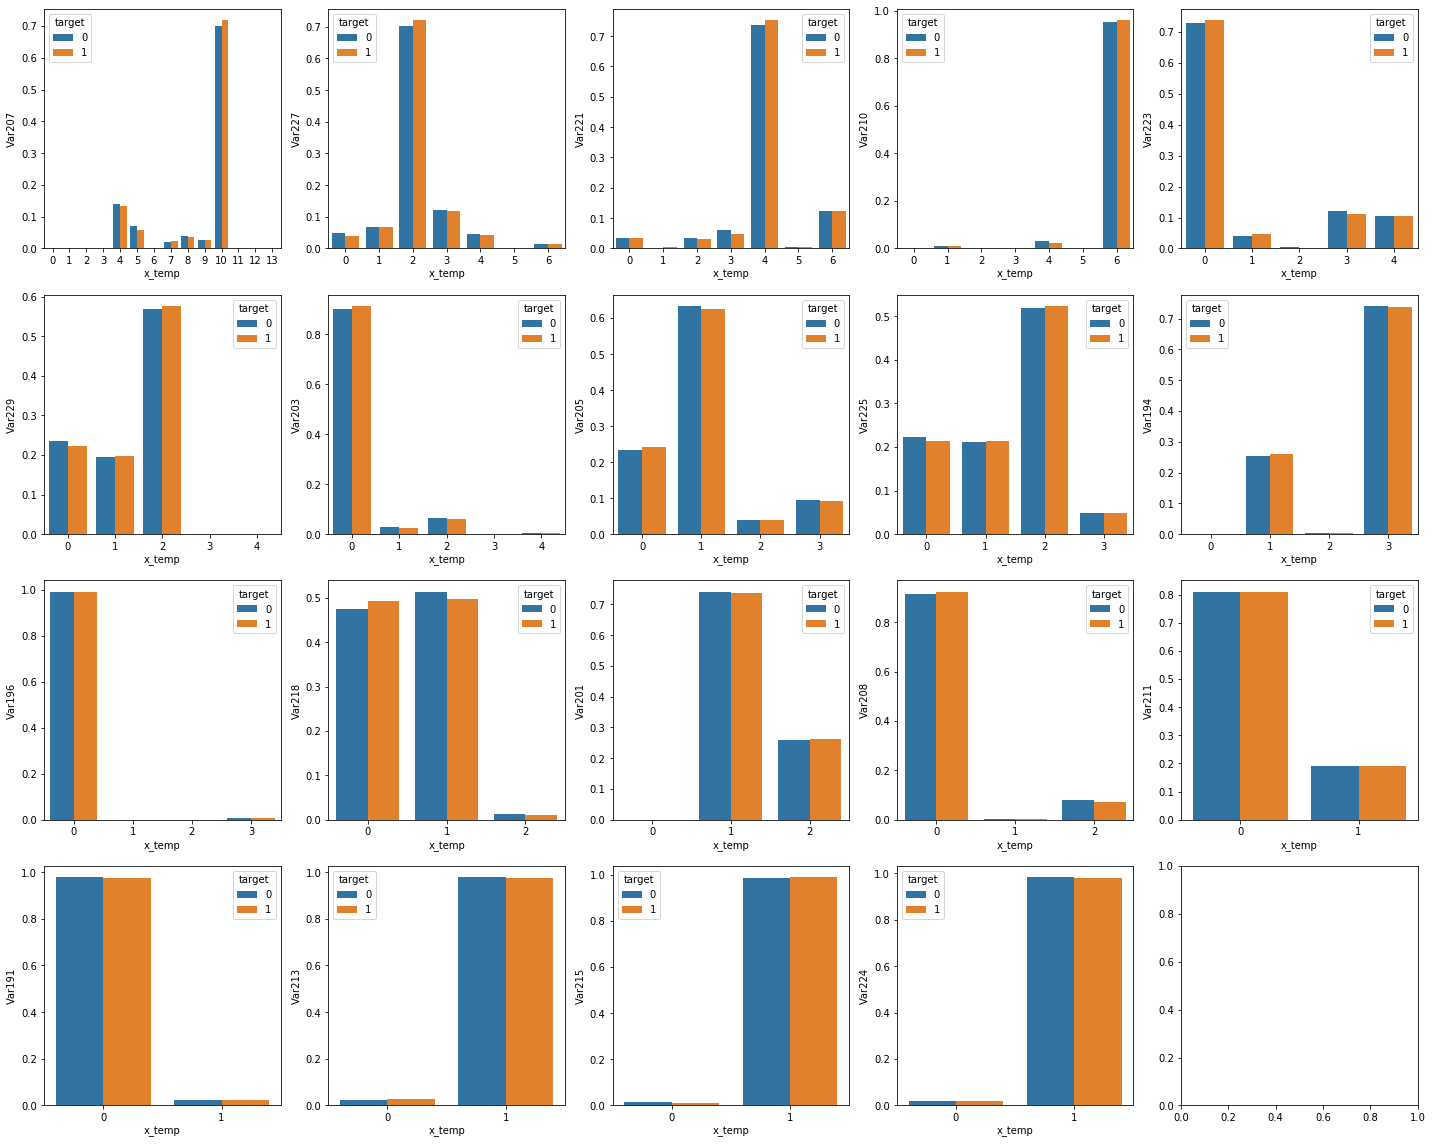

In [329]:
data_new = data[list(features) + ['target']]
len1_class = data_new[data_new['target']==1].shape[0]
len0_class = data_new[data_new['target']==0].shape[0]

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for i, fear in enumerate(features):
    temp_1 = data_new[fear][data_new['target']==1].value_counts()
    temp_1 = temp_1.apply(lambda x: x/len1_class)
    temp_1 = pd.DataFrame(temp_1)
    temp_1['target']=1

    temp_0 = data_new[fear][data_new['target']==0].value_counts()
    temp_0 = temp_0.apply(lambda x: x/len0_class)
    temp_0 = pd.DataFrame(temp_0)
    temp_0['target']=0

    temp_df = pd.concat([temp_1, temp_0])
    temp_df['x_temp']=temp_df.index

    sns.barplot(x=temp_df['x_temp'], y=temp_df[temp_df.columns[0]], hue=temp_df['target'], ax=axes[i // 5, i % 5])
fig.tight_layout()

Помимо того, что при достаточно большом количестве уникальных значений в таких графиках ничего нельзя разглядеть, даже для уже построенных графиков трудно понять какие значения могут помочь в разделении классов, а какие нет. Здесь надо принять во внимание смещенность исходной выборки в сторону класса "не отток", доля которого почти 93%. Поэтому сделаем нормировку на размеры классов. Полученные распределения для категориальных признаков показывают, что доля классов с разными значениями категориальных признаков одна и та же. Возможно нужно смотреть на совокупность нескольких категориальных признаков вместе. 

#### 8. Проанализируйте полученные результаты:

- Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?

- На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?

- Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?

- Как вы думаете, окажется ли отбор признаков полезным для построения модели?

Числовые признаки: 

    1) много признаков с большим числом пропущенных значений
    2) есть признаки, имеющие корреляции с целевой переменной
    3) есть признаки, не имеющие корреляций с целевой переменной

Категориальные признаки:
    
    1) Есть константные признаки (они бесполезны)
    2) Есть признаки, которые коррелируют с целевой переменной сильнее всего
    3) Относительное распределение значений категориальных признаков для обоих классов примерно одинаковое 

Отбор признаков полезен для данной задачи (как минимум, устраним константные признаки)